# Load Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import json
import csv
import librosa
import librosa.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from pprint import pprint
%matplotlib inline

from functions.functions_features import split_audio, mean_variance_normalize, process_row, pad_array, process_CNN_row

# Load data

In [2]:
df_all = pd.read_csv('Results/Data/data_all.csv')
df_all

,dataset,filepath,filename,age,gender,label,status,prob
0,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_cough-shallow,28.0,male,1,healthy,NaN
1,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_cough-heavy,28.0,male,1,healthy,NaN
2,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_breathing-shallow,28.0,male,0,healthy,NaN
3,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_vowel-a,28.0,male,0,healthy,NaN
4,coswara,Dataset/Coswara-Data/Extracted_data/20200424/i...,iV3Db6t1T8b7c5HQY2TwxIhjbzD3_vowel-o,28.0,male,0,healthy,NaN
...,...,...,...,...,...,...,...,...
72335,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-097-cough-m-37-4.wav,37.0,male,1,negative,NaN
72336,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-097-cough-m-37-1.wav,37.0,male,1,negative,NaN
72337,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-098-cough-f-24-5.wav,24.0,female,1,negative,NaN
72338,virufy,Dataset/virufy-data/clinical/segmented/neg/neg...,neg-0422-098-cough-f-24-0.wav,24.0,female,1,negative,NaN


In [3]:
Counter(df_all['dataset'].tolist())

Counter({'coughvid': 34434,
         'coswara': 24712,
         'fsdkaggle': 11073,
         'esc50': 2000,
         'virufy': 121})

# Extract Features

In [4]:
# Get columns
columns = [
    'dataset', 'filepath', 'filename', 
    'age', 'gender', 'label', 'status', 'duration', 
    'duration_segment', 'sample_frequency', 'mean_amplitude',
    'mean', 'variance', 'std_dev', 'max_value', 'min_value', 'rms',
    'skewness', 'kurtosis', 'median', 'range_val', 'iqr',
    'zcr', 'energy', 'rmse', 'entropy',
    'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
    'spectral_flatness', 'spectral_rolloff', 'chroma_stft',
    ]

for i in range(1, 21):
    columns.append(f'mfcc_mean_{i}_mean')
    columns.append(f'mfcc_{i}_std')

In [5]:
list_dataset_name = [
    'coswara', 
    'coughvid', 
    'esc50', 
    'fsdkaggle', 
    'virufy',
    ]

if not os.path.exists(f'Results/Features'):
    os.makedirs(f'Results/Features')

overlap=0 # To avoid overfitting when doing kfold

In [6]:
for segment_length in [1, 5, 10]:
    for dataset_name in list_dataset_name:
        print('\n', dataset_name, segment_length)
        
        df_all = pd.read_csv(f'Results/Data/data_summary_{dataset_name}.csv')
        df_all = df_all.sample(frac=1).groupby('label').head(1000).reset_index(drop=True)
        
        path_save = f'Results/Features/data_{dataset_name}_features_{segment_length}s_{overlap}.csv'
    
        if os.path.exists(path_save) == False:
        # if os.path.exists(path_save) == True:
            results_all = []
                
            total_len = len(df_all)
            for i in tqdm(range(total_len)):
                results_all.extend(process_row(i, df_all, segment_length, overlap))
        
            results_all_df = pd.DataFrame(results_all, columns=columns)
            results_all_df.to_csv(path_save, index=False)
            print(results_all_df.shape)

coswara 1


100%|██████████| 2000/2000 [08:37<00:00,  3.86it/s]


(17798, 72)
coughvid 1


100%|██████████| 2000/2000 [18:14<00:00,  1.83it/s]


(16772, 72)
esc50 1


100%|██████████| 1040/1040 [10:38<00:00,  1.63it/s]


(5200, 72)
fsdkaggle 1


100%|██████████| 1273/1273 [12:36<00:00,  1.68it/s]


(8795, 72)
virufy 1


100%|██████████| 121/121 [00:17<00:00,  6.80it/s]


(242, 72)
coswara 5


100%|██████████| 2000/2000 [11:19<00:00,  2.94it/s]


(4281, 72)
coughvid 5


100%|██████████| 2000/2000 [10:27<00:00,  3.19it/s]


(3707, 72)
esc50 5


100%|██████████| 1040/1040 [03:30<00:00,  4.93it/s]


(1040, 72)
fsdkaggle 5


100%|██████████| 1273/1273 [04:18<00:00,  4.93it/s]


(2377, 72)
virufy 5


100%|██████████| 121/121 [00:06<00:00, 17.75it/s]


(121, 72)
coswara 10


100%|██████████| 2000/2000 [08:07<00:00,  4.10it/s]


(2604, 72)
coughvid 10


100%|██████████| 2000/2000 [08:03<00:00,  4.13it/s]


(2091, 72)
esc50 10


100%|██████████| 1040/1040 [02:45<00:00,  6.30it/s]


(1040, 72)
fsdkaggle 10


100%|██████████| 1273/1273 [03:59<00:00,  5.31it/s]


(1623, 72)
virufy 10


100%|██████████| 121/121 [00:06<00:00, 17.89it/s]

(121, 72)


# Analyze features

In [6]:
segment_length = 10
df_all_combined = pd.DataFrame()
results_all = []

for dataset_name in list_dataset_name:
    ############################################################
    # Load data
    ############################################################
    print(dataset_name)
    df_all = pd.read_csv(f'Results/Features/data_{dataset_name}_features_{segment_length}s_{overlap}.csv')
    
    list_duration = df_all['duration']
    
    results = [dataset_name, 
               np.median(list_duration), np.mean(list_duration), 
               np.min(list_duration), np.max(list_duration),
               ]
    
    results_all.append(results)

    ############################################################
    # Clean data
    ############################################################
    df_all = df_all.drop(['filepath', 'age', 'gender', 'status'], axis=1)
    df_all_combined = pd.concat([df_all_combined, df_all], axis=0).reset_index(drop=True)
    
df_all_combined.to_csv(f'Results/Features/data_combined_features.csv', index=False)

columns = ['dataset', 'median', 'mean', 'min', 'max']
results_all = pd.DataFrame(results_all, columns=columns)
results_all.to_csv(f'Results/Features/data_combined_duration.csv', index=False)

df_all_combined = df_all_combined.drop(['dataset', 'filename'], axis=1)
df_all_combined = df_all_combined.fillna(0)
df_all_combined

coswara
coughvid
esc50
fsdkaggle
virufy


,label,duration,duration_segment,sample_frequency,mean_amplitude,mean,variance,std_dev,max_value,min_value,...,mfcc_mean_16_mean,mfcc_16_std,mfcc_mean_17_mean,mfcc_17_std,mfcc_mean_18_mean,mfcc_18_std,mfcc_mean_19_mean,mfcc_19_std,mfcc_mean_20_mean,mfcc_20_std
0,0,3.840000,3.840000,22050,0.032927,-5.710422e-09,1.0,1.0,7.557480,-7.654074,...,0.254319,4.095388,-3.431260,4.430245,-4.903201,5.249034,-4.865901,5.134549,-6.821688,7.399064
1,0,9.386667,9.386667,22050,0.030379,-6.897846e-09,1.0,1.0,3.854099,-4.514576,...,-32.500214,17.198618,-3.138359,5.868192,-7.242890,7.173791,-12.509939,7.202513,-2.037359,6.815511
2,1,7.253333,7.253333,22050,0.011609,-7.632448e-10,1.0,1.0,24.170200,-24.403107,...,-1.807878,8.088194,-3.029291,9.824522,-1.572867,6.994999,-5.107709,7.541216,0.727968,8.482310
3,0,19.712018,10.000000,22050,0.044535,-9.143164e-09,1.0,1.0,6.131506,-8.807899,...,-8.334073,7.857934,-2.138956,6.976721,-4.796892,6.925023,-6.084177,6.147591,-7.684732,7.586441
4,0,19.712018,9.712018,22050,0.037718,4.264314e-09,1.0,1.0,5.911465,-9.434145,...,-9.710259,7.881359,-3.950834,6.781555,-6.635819,7.492670,-9.118374,8.007632,-8.665564,7.143835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,1,1.599909,1.599909,22050,0.031612,1.845010e-09,1.0,1.0,7.941133,-7.515191,...,-3.514017,6.607751,-3.754806,7.727861,-5.257544,9.251544,-2.657506,5.878861,-0.369615,5.038404
7475,1,1.599864,1.599864,22050,0.017201,4.410114e-09,1.0,1.0,14.303961,-11.151936,...,-5.892507,9.114714,-1.125595,3.750649,-1.698090,3.392350,0.179801,4.295675,-1.177636,3.342858
7476,1,1.599909,1.599909,22050,0.066963,4.257716e-09,1.0,1.0,5.826554,-5.524630,...,-5.000772,10.246392,3.143608,4.925082,-6.378663,11.112607,-0.159873,7.481751,4.450074,5.621959
7477,1,1.599909,1.599909,22050,0.046452,3.624972e-09,1.0,1.0,7.007829,-7.128371,...,-9.325192,12.509102,-2.826368,8.537502,-1.829659,3.631592,0.104567,5.620127,-6.048389,8.822038


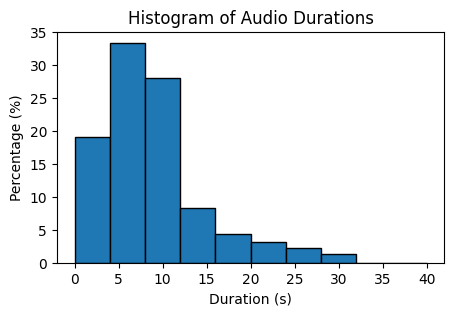

In [16]:
values = df_all_combined['duration']
list_range = (0, 40)

bins = 10

# Calculate histogram data
counts, bin_edges = np.histogram(values, bins=bins)
total = sum(counts)


plt.figure(figsize=(5, 3))
# Plot histogram with percentage weights
plt.hist(values, bins=bins, 
         weights=np.ones_like(values) * 100 / len(values),
         range = list_range,
         edgecolor='black')


# Add title and labels
plt.title('Histogram of Audio Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Percentage (%)')

# Show the plot
plt.show()